# Wykrywanie naczyń dna oka

## Imports

In [1475]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from skimage import io, color, exposure
from skimage.transform import rescale
from skimage.filters import unsharp_mask, frangi, hessian, sato

## Constants

In [1476]:
PATH = "Image_05L"
ORIGINAL_PHOTO_NAME = "photos/{0}.jpg".format(PATH)
ORIGINAL_PHOTO_HOLD_OUT = "photos/{0}_1stHO.png".format(PATH)

## Functions

In [1477]:
def loadImage(file):
    img = cv2.imread(file, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (400, 400), interpolation=cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [1478]:
def showImages(img1, img2, img3):
    fig = plt.figure(figsize=(20, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(img1)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(img2, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(img3, cmap='gray')
    plt.axis('off')

In [1479]:
def preProcessing(img, optionNumbers):
    for num in optionNumbers:
        if num == 0:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        elif num == 1:
            img = cv2.Laplacian(img, 3) # test
        elif num == 2:
            img = unsharp_mask(img, radius=5, amount=2)
        elif num == 3:
            img = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        elif num == 4:
            img = cv2.equalizeHist(np.uint8(img))
        elif num == 5:
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            img = clahe.apply(img)
        elif num == 6:
            img = cv2.erode(img, np.ones((1,1), np.uint8), iterations=1) 
        elif num == 7:
            img = cv2.dilate(img, np.ones((5,5), np.uint8), iterations=1)
    return img

In [1480]:
def properProcessing(img):
    img = sato(img)
    return img

In [1481]:
def removeBorder(original, img):
    for i in range(len(original)):
        for j in range(len(original[0])):
            if original[i][j] == False:
                img[i][j] = 0
    return img 

## Main

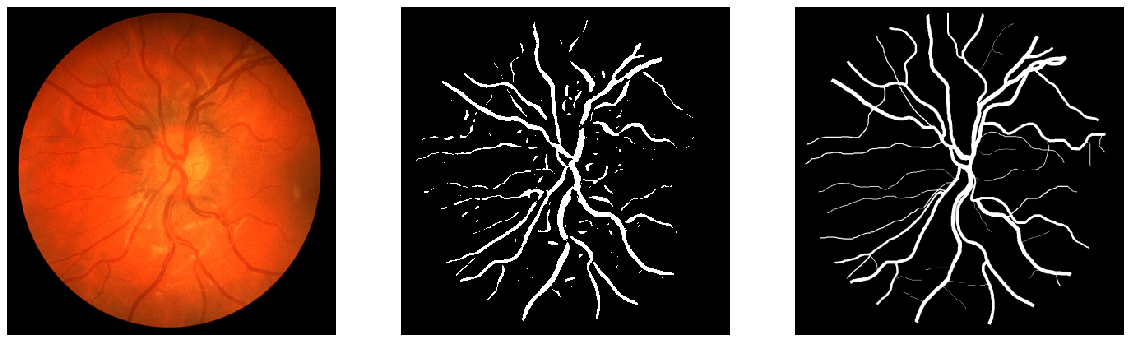

In [1482]:
originalImage = loadImage(ORIGINAL_PHOTO_NAME)

preparedImage = preProcessing(originalImage, [0, 5, 2]) # nr 4 jest jeszcze niezle
resultImage = properProcessing(preparedImage)
resultImage = preProcessing(resultImage, [6, 2, 3])
resultImage = removeBorder(preProcessing(originalImage, [0]) > 40, resultImage)
holdOut = loadImage(ORIGINAL_PHOTO_HOLD_OUT)

showImages(originalImage, resultImage > 42, holdOut)